<a href="https://colab.research.google.com/github/u0sama/PSX-DATA-WITH-RSI-SIGNALS/blob/main/Psx_RSI_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#user input
Symbol = 'WCTL'
Start = "1/11/2021"
To = "24/1/2022"
#Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
Granularity= "Daily"
Fast=50
Slow=200
#PERIODS FOR RSI
RSIP=20
#RSI LIMITS FOR BUY
RSILB=15
RSIHB=25
#RSI LIMITS FOR SELL
RSILS=65
RSIHS=90

In [2]:
%pip install yfinance
%pip install mpl_finance
%pip install investpy


     |████████████████████████████████| 6.4 MB 9.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.4 MB 6.7 MB/s 
     |████████████████████████████████| 235 kB 74.9 MB/s 
     |████████████████████████████████| 503 kB 74.9 MB/s 
  Created wheel for investpy: filename=inv

In [10]:
import pandas as pd
import investpy
import yfinance as yf
import numpy as np
import math
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt# get stock prices using yfinance library
plt.rcParams['figure.figsize'] = [16, 12]

plt.rc('font', size=14) 
df = investpy.get_stock_historical_data(stock= Symbol,
                                        country='Pakistan',
                                        from_date= Start,
                                        to_date=To, interval= Granularity)

df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)
df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df['Fast_EMA'] = df['Close'].ewm(span = Fast, adjust = False).mean()
df['Slow_EMA'] = df['Close'].ewm(span = Slow, adjust = False).mean()
ret =df['Close'].diff()
up = []
down = []
for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
up_series = pd.Series(up)
down_series = pd.Series(down).abs()
up_ewm = up_series.ewm(com = RSIP - 1, adjust = False).mean()
down_ewm = down_series.ewm(com = RSIP - 1, adjust = False).mean()
rs = up_ewm/down_ewm
rsi = 100 - (100 / (1 + rs))
rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(df['Close'].index)
rsi_df = rsi_df.dropna()
df['RSI']=rsi_df[3:]
df


,Date,Open,High,Low,Close,Volume,Fast_EMA,Slow_EMA,RSI
Date,,,,,,,,,
2021-11-01,738095.0,2.42,2.54,2.36,2.50,53862000,2.500000,2.500000,NaN
2021-11-02,738096.0,2.46,2.52,2.40,2.43,10243000,2.497255,2.499303,NaN
2021-11-03,738097.0,2.42,2.50,2.41,2.43,16290000,2.494617,2.498614,NaN
2021-11-04,738098.0,2.44,2.70,2.44,2.65,81042000,2.500711,2.500120,NaN
2021-11-05,738099.0,2.68,2.80,2.66,2.70,41910000,2.508526,2.502109,81.187087
...,...,...,...,...,...,...,...,...,...
2022-01-18,738173.0,2.39,2.42,2.32,2.35,17672000,2.255645,2.379545,54.024517
2022-01-19,738174.0,2.36,2.36,2.13,2.16,27328000,2.251894,2.377360,46.786811
2022-01-20,738175.0,2.16,2.20,2.03,2.19,27947500,2.249467,2.375496,47.945880


In [11]:
bdf = df.loc[df['RSI'] > RSILB] 
bdf = bdf.loc[bdf['RSI'] <RSIHB]

print("RSI BUY SIGNAL")

bdf

RSI BUY SIGNAL


,Date,Open,High,Low,Close,Volume,Fast_EMA,Slow_EMA,RSI
Date,,,,,,,,,


In [12]:
sdf = df.loc[df['RSI'] > RSILS] 
sdf = sdf.loc[sdf['RSI'] < RSIHS]

print("RSI SELL SIGNAL")

sdf

RSI SELL SIGNAL


,Date,Open,High,Low,Close,Volume,Fast_EMA,Slow_EMA,RSI
Date,,,,,,,,,
2021-11-05,738099.0,2.68,2.8,2.66,2.7,41910000,2.508526,2.502109,81.187087


In [13]:
def isSupport(df,i):
  support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] \
  and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]

  return support

def isResistance(df,i):
  resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] \
  and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2] 

  return resistance

In [16]:
levels = []
levelr = []
levelsp = []
levelre= []
a=1
b=1
for i in range(2,df.shape[0]-2):
  if isSupport(df,i):
    
    levels.append((i,df['Low'][i]))
    levelsp.append((a,df['Low'][i]))
    a=a+1


  elif isResistance(df,i):
  
    levelr.append((i,df['High'][i]))
    levelre.append((b,df['High'][i]))
    b=b+1

In [14]:
def plot_all():
  fig, ax = plt.subplots()

  candlestick_ohlc(ax,df.values,width=0.6, \
                   colorup='green', colordown='red', alpha=0.8)

  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()

  fig.tight_layout()
  df['Fast_EMA'].plot(color = 'red', lw = 2.5, label="Fast EMA") 
  df['Slow_EMA'].plot(color = 'green', lw = 2.5,label="Slow EMA")
  ax.plot(bdf.index, bdf.Close, marker = '^', markersize = 10, color = 'blue', label = 'BUY SIGNAL')
  ax.plot(sdf.index, sdf.Close, marker = 'v', markersize = 10, color = 'black', label = 'Sell SIGNAL')

  for level in levels:
    plt.hlines(level[1],xmin=df['Date'][level[0]],\
               xmax=max(df['Date']),colors='green', linestyle="dashed")
  #plt.text(max(df['Date']), df['Date'][level[0]], ' somelabel1')

    
  for level in levelr:
    plt.hlines(level[1],xmin=df['Date'][level[0]],\
               xmax=max(df['Date']),colors='red',linestyle="dashed")
    T= "Method1 Supports and Resistance of " + Symbol
    
    plt.title(T)
    plt.legend()

    
  fig.show()
  fig, ax = plt.subplots(figsize=(19.5, 4))
  df['RSI'].plot( color = 'orange', linewidth = 2.5)
  
  plt.axhline(RSILB, linestyle = '--', linewidth = 1.5, color = 'green')
  plt.axhline(RSIHB, linestyle = '--', linewidth = 1.5, color = 'green')
  plt.axhline(RSILS, linestyle = '--', linewidth = 1.5, color = 'red')
  plt.axhline(RSIHS, linestyle = '--', linewidth = 1.5, color = 'red')
  T= "RSI(" +str(RSIP)+") :"+ Symbol

  plt.title(T)
  plt.legend()
  plt.grid()
  plt.box(False)
  plt.ylabel("RSI")
  plt.xlabel("Datetime")

  fig.show

Supports Points
1 2.32
2 2.04
3 1.59
 
 
Resistance Points
1 2.8
2 2.46
3 2.25
4 2.29
5 2.68


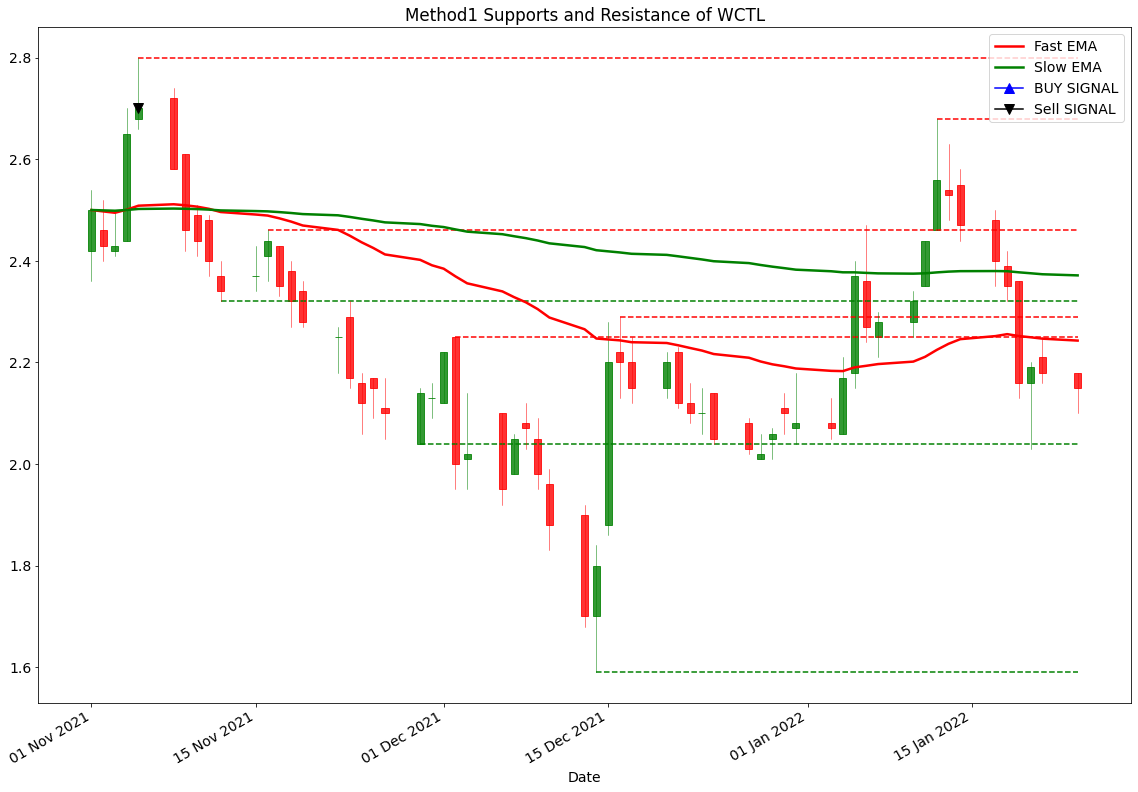

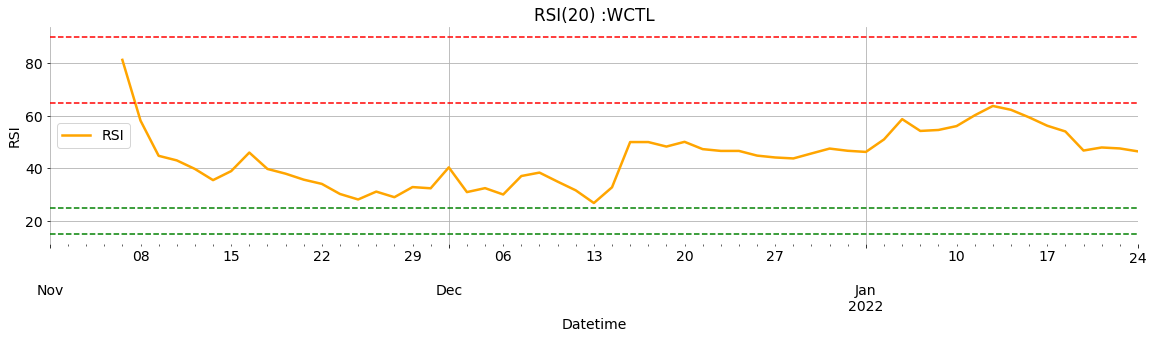

In [17]:
print ("Supports Points")


for line in levelsp:
    print(*line)


print (" ") 
print (" ") 

print ("Resistance Points") 
for line1 in levelre:
    print(*line1)



plot_all()



Supports Points
1 1.59
2 2.01
 
 
Resistance Points
1 2.8
2 2.25
3 2.29
4 2.68


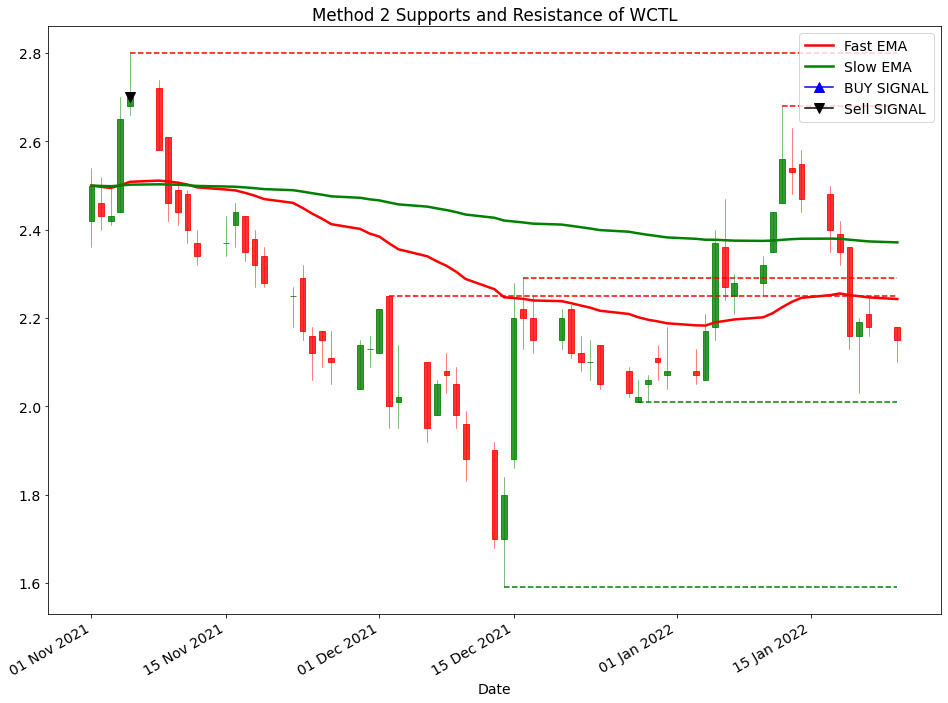

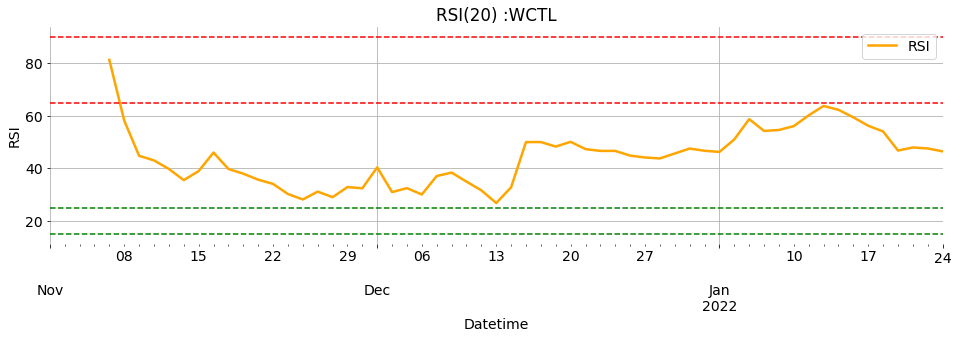

In [18]:
def plot_all1(level1, level2, df):
    fig, ax = plt.subplots(figsize=(16, 12))
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    df['Fast_EMA'].plot(color = 'red', lw = 2.5, label="Fast EMA") 
    df['Slow_EMA'].plot(color = 'green', lw = 2.5,label="Slow EMA")
    ax.plot(bdf.index, bdf.Close, marker = '^', markersize = 10, color = 'blue', label = 'BUY SIGNAL')
    ax.plot(sdf.index, sdf.Close, marker = 'v', markersize = 10, color = 'black', label = 'Sell SIGNAL')
    for level in level1:
      plt.hlines(level[1],xmin=df['Date'][level[0]],\
               xmax=max(df['Date']),colors='green', linestyle="dashed")
  #plt.text(max(df['Date']), df['Date'][level[0]], ' somelabel1')

    
    for level in level2:
      plt.hlines(level[1],xmin=df['Date'][level[0]],\
               xmax=max(df['Date']),colors='red',linestyle="dashed")
   
   
  #plt.text(max(df['Date']), df['Date'][level[0]], ' somelabel1')

    
    
    T= "Method 2 Supports and Resistance of " + Symbol
    
    plt.title(T)
    plt.legend()

    fig.show()
    fig, ax = plt.subplots(figsize=(16, 4))
    df['RSI'].plot( color = 'orange', linewidth = 2.5)
  
    plt.axhline(RSILB, linestyle = '--', linewidth = 1.5, color = 'green')
    plt.axhline(RSIHB, linestyle = '--', linewidth = 1.5, color = 'green')
    plt.axhline(RSILS, linestyle = '--', linewidth = 1.5, color = 'red')
    plt.axhline(RSIHS, linestyle = '--', linewidth = 1.5, color = 'red')
    T= "RSI(" +str(RSIP)+") :"+ Symbol

    plt.title(T)
    plt.legend()
    plt.grid()
    plt.box(False)
    plt.ylabel("RSI")
    plt.xlabel("Datetime")

    fig.show
def is_support(df,i):
  cond1 = df['Low'][i] < df['Low'][i-1] 
  cond2 = df['Low'][i] < df['Low'][i+1] 
  cond3 = df['Low'][i+1] < df['Low'][i+2] 
  cond4 = df['Low'][i-1] < df['Low'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_resistance(df,i):
  cond1 = df['High'][i] > df['High'][i-1] 
  cond2 = df['High'][i] > df['High'][i+1] 
  cond3 = df['High'][i+1] > df['High'][i+2] 
  cond4 = df['High'][i-1] > df['High'][i-2]
  return (cond1 and cond2 and cond3 and cond4)
def is_far_from_level(value, levels, df):
    ave =  np.mean(df['High'] - df['Low'])
    return np.sum([abs(value - level) < ave for _, level in levels]) == 0
#method 1: fractal candlestick pattern
def detect_level_method_1(df):
  levels = []
  for i in range(2,df.shape[0]-2):
    if is_support(df,i):
      l = df['Low'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l))
    elif is_resistance(df,i):
      l = df['High'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l))
  return levels

#method 2: window shifting method
def detect_level_method_2(df):
  levels = []

  max_list = []
  min_list = []
  for i in range(5, len(df)-5):
      high_range = df['High'][i-5:i+4]
      current_max = high_range.max()
      if current_max not in max_list:
          max_list = []
      max_list.append(current_max)
      if len(max_list) == 5 and is_far_from_level(current_max, levels, df):
          levels.append((high_range.idxmax(), current_max))
      
      low_range = df['Low'][i-5:i+5]
      current_min = low_range.min()
      if current_min not in min_list:
          min_list = []
      min_list.append(current_min)
      if len(min_list) == 5 and is_far_from_level(current_min, levels, df):
          levels.append((low_range.idxmin(), current_min))
  return levels

pivots = []
pivotse = []

pivotr = []
pivotre = []
a=1
b=1

max_list = []
min_list = []
for i in range(5, len(df)-5):
    high_range = df['High'][i-5:i+4]
    current_max = high_range.max()

    if current_max not in max_list:
        max_list = []
    max_list.append(current_max)
    if len(max_list) == 5 and is_far_from_level(current_max, pivots, df):
        pivotr.append((high_range.idxmax(), current_max))
        pivotre.append((a, current_max))
        a=a+1
    
    low_range = df['Low'][i-5:i+5]
    current_min = low_range.min()
    if current_min not in min_list:
        min_list = []
    min_list.append(current_min)
    if len(min_list) == 5 and is_far_from_level(current_min, pivots, df):
        pivots.append((low_range.idxmin(), current_min))
        pivotse.append((b, current_min))
        b=b+1

print ("Supports Points")


for line3 in pivotse:
    print(*line3)


print (" ") 
print (" ") 

print ("Resistance Points") 
for line4 in pivotre:
    print(*line4)
plot_all1(pivots, pivotr,df)